In [ ]:
# Статический вывод графики (графики отображаются в той ячейке, в которой используется plt.show())
%matplotlib inline

import pandas as pd # импортируем библиотеку обработки и анализа данных pandas
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
import numpy as np # Импортируем библиотеку numpy
from keras.preprocessing.text import Tokenizer, text_to_word_sequence,tokenizer_from_json 

from sklearn.preprocessing import StandardScaler, LabelEncoder # Импортируем библиотеку StandardScaler и LabelEncoder
from sklearn.cluster import KMeans # Импортируем библиотуке KMeans для кластеризации
from sklearn.metrics.cluster import homogeneity_score
from sklearn.manifold import TSNE
import time
import os

from tensorflow.keras.models import Sequential, Model # Полносвязная модель
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Reshape, Conv2DTranspose, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation # Слои для сети
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Подключаем диск
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/My Drive/datasets/texts/Тексты писателей.zip' -d '/content/texts'

In [ ]:
def readText(fileName): # Объявляем функции для чтения файла. На вход отправляем путь к файлу  
  f = open(fileName, 'r')        # Задаем открытие нужного файла в режиме чтения
  text = f.read()                # Читаем текст
  text = text.replace("\n", " ") # Переносы строки переводим в пробелы
  
  return text                    # Возвращаем текст файла

className = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдберри"] # Объявляем интересующие нас классы
nClasses = len(className) # Считаем количество классов

# Формирование обучающей выборки по листу индексов слов
# (разделение на короткие векторы)
def getSetFromIndexes(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна
  xSample = [] # Объявляем переменную для векторов
  wordsLen = len(wordIndexes) # Считаем количество слов
  index = 0 # Задаем начальный индекс 

  while (index + xLen <= wordsLen):# Идём по всей длине вектора индексов
    xSample.append(wordIndexes[index:index+xLen]) # "Откусываем" векторы длины xLen
    index += step # Смещаеммся вперёд на step
    
  return xSample
  
# Формирование обучающей и проверочной выборки
# Из двух листов индексов от двух классов
def createSetsMultiClasses(wordIndexes, xLen, step): # Функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # Задаем количество классов выборки
  classesXSamples = []        # Здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
  for wI in wordIndexes:      # Для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # Добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 

  # Формируем один общий xSamples
  xSamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна (например, 15779*1000)"
  ySamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"
  
  for t in range(nClasses): # В диапазоне кол-ва классов(6)
    xT = classesXSamples[t] # Берем очередной текст вида "кол-во окон в тексте*длину окна"(например, 1341*1000)
    for i in range(len(xT)): # И каждое его окно
      xSamples.append(xT[i]) # Добавляем в общий список выборки
      ySamples.append(utils.to_categorical(t, nClasses)) # Добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # Переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # Переводим в массив numpy для подачи в нейронку

  
  return (xSamples, ySamples) #Функция возвращает выборку и соответствующие векторы классов

In [ ]:
trainText = [] #Формируем обучающие тексты
testText = [] #Формируем тестовые тексты

#Формирование необходимо произвести следующим образом 
#Класс каждого i-ого эллемента в обучающей выборке должен соответствовать 
#классу каждого i-ого эллемента в тестовой выборке

for i in className: #Проходим по каждому классу
  for j in os.listdir('texts/'): #Проходим по каждому файлу в папке с текстами #
    if i in j: #Проверяем, содержит ли файл j в названии имя класса i
      
      if 'Обучающая' in j: #Если в имени найденного класса есть строка "Обучающая" 
        trainText.append(readText('texts/' + j)) #добавляем в обучающую выборку
        print(j, 'добавлен в обучающую выборку') #Выводим информацию
      if 'Тестовая' in j: #Если в имени найденного класса есть строка "Тестовая"
        testText.append(readText('texts/' + j)) #добавляем в обучающую выборку
        print(j, 'добавлен в тестовую выборку') #Выводим информацию
  print()

(О. Генри) Обучающая_50 вместе.txt добавлен в обучающую выборку
(О. Генри) Тестовая_20 вместе.txt добавлен в тестовую выборку

(Стругацкие) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Булгаков) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Клиффорд_Саймак) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Клиффорд_Саймак) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Макс Фрай) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Макс Фрай) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Рэй Брэдберри) Обучающая_22 вместе.txt добавлен в обучающую выборку
(Рэй Брэдберри) Тестовая_8 вместе.txt добавлен в тестовую выборку



In [ ]:
# Задаём базовые параметры
xLen = 1000  # Длина отрезка текста, по которой анализируем, в словах
step = 100  # Шаг разбиения исходного текста на обучающие векторы
maxWordsCount = 50000
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(trainText)
# Преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # Обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)  # Проверочные тесты в индексы
# Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)  # извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    # извлекаем тестовую выборку

In [ ]:
xTrain.shape, yTrain.shape, xTest.shape, yTest.shape

((17640, 1000), (17640, 6), (6686, 1000), (6686, 6))

In [ ]:
def createEmbeddingModel(dim=128, xLen=1000, neurons=1024, activation='softmax'):
    inp = Input(shape=(xLen))
    emb = Embedding(maxWordsCount, dim, input_length=xLen)(inp)
    x = SpatialDropout1D(0.2)(emb)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(neurons, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    out = Dense(6, activation='softmax')(x)

    model = Model(inp, out)
    embed = Model(inp, emb)

    model.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
    return model, embed

In [ ]:
model, embed = createEmbeddingModel()

Epoch 1/15
276/276 [==============================] - 23s 76ms/step - loss: 1.8593 - accuracy: 0.6761 - val_loss: 1.4547 - val_accuracy: 0.4809
Epoch 2/15
276/276 [==============================] - 21s 74ms/step - loss: 0.0071 - accuracy: 0.9996 - val_loss: 1.2609 - val_accuracy: 0.5390
Epoch 3/15
276/276 [==============================] - 20s 74ms/step - loss: 0.0019 - accuracy: 0.9998 - val_loss: 1.1956 - val_accuracy: 0.6168
Epoch 4/15
276/276 [==============================] - 20s 74ms/step - loss: 8.9866e-04 - accuracy: 1.0000 - val_loss: 1.2000 - val_accuracy: 0.6297
Epoch 5/15
276/276 [==============================] - 20s 74ms/step - loss: 4.8795e-04 - accuracy: 1.0000 - val_loss: 1.1898 - val_accuracy: 0.6342
Epoch 6/15
276/276 [==============================] - 20s 74ms/step - loss: 4.0580e-04 - accuracy: 1.0000 - val_loss: 1.2472 - val_accuracy: 0.6255
Epoch 7/15
276/276 [==============================] - 20s 74ms/step - loss: 2.3921e-04 - accuracy: 1.0000 - val_loss: 1.2483

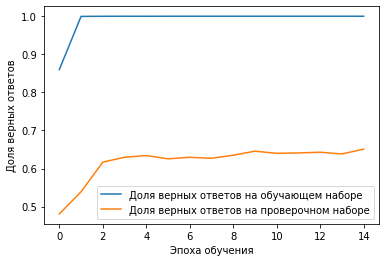

In [ ]:
history = model.fit(xTrain, yTrain, epochs=15, batch_size=64, verbose=1, validation_data=(xTest, yTest))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()                 
                                

In [ ]:
ids = np.array([i for i in range(maxWordsCount)]).reshape(-1, xLen)
ids.shape

(50, 1000)

In [ ]:
# Делаем предикт моделью
dim = 128
zTrain = embed.predict(ids)
zTrain = zTrain.reshape(-1, dim)
zTrain.shape

(50000, 128)

In [ ]:
# Попробуем кластеризовать слова по писателям.
km = KMeans(6)
km.fit(zTrain)

pred = km.predict(zTrain)
pred[:20]

array([4, 1, 4, 4, 5, 5, 0, 3, 5, 0, 0, 3, 5, 0, 2, 0, 1, 3, 1, 1],
      dtype=int32)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


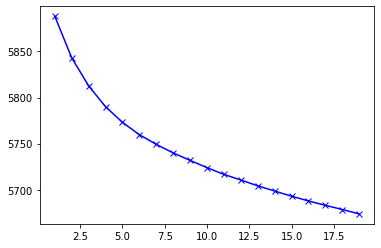

CPU times: user 13min 39s, sys: 3min 26s, total: 17min 5s
Wall time: 13min 8s


In [ ]:
%%time
n_clusters = 20               # Зададим количество кластеров
cost = []                     # Создаем пустой список
for i in range(1, n_clusters): # Пробегаем по списку от 1 до n_clusters
    kmean = KMeans(i)           # Создаем объект KMeans с i-классами
    kmean.fit(zTrain)   # Проводим кластеризацию zTrain
    cost.append(kmean.inertia_) # Добавляем в cost элемент kmean.inertia_
    print(i, end=' ')
print()
  
# inertia_ - это среднее растояние от точек до центров их классов
# Может использоваться для подбора оптимального количества классов 

# Отобразим значения списка cost на графике
plt.plot([i for i in range(1, n_clusters)], cost, 'bx-')
plt.show()

In [ ]:
km = KMeans(200)
km.fit(zTrain)

pred = km.predict(zTrain)
pred[:10]

array([ 42,   1,  31,  76,  25,  24, 131,  40,  25, 197], dtype=int32)

In [ ]:
voc = [i for i in range(50000)]
voc[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
cnt = 0
print("cluster #%d"%i, end=": ")
  for j in range(50000):
      if pred[j] == i:
          print(tokenizer.index_word[j], end=" ")
          cnt += 1
          if cnt == 20:
                print()
                break

cluster #19: таких виду нашей крайней ответ жалко порой советник долговязый север синие коридору усы сухой смертью куртки персоной валя женщиной холме 


Epoch 1/15
276/276 [==============================] - 40s 140ms/step - loss: 1.9910 - accuracy: 0.6865 - val_loss: 1.5098 - val_accuracy: 0.4635
Epoch 2/15
276/276 [==============================] - 39s 140ms/step - loss: 0.0080 - accuracy: 0.9996 - val_loss: 1.2591 - val_accuracy: 0.5410
Epoch 3/15
276/276 [==============================] - 39s 140ms/step - loss: 0.0020 - accuracy: 0.9999 - val_loss: 1.2371 - val_accuracy: 0.6010
Epoch 4/15
276/276 [==============================] - 39s 140ms/step - loss: 9.5234e-04 - accuracy: 1.0000 - val_loss: 1.2512 - val_accuracy: 0.6102
Epoch 5/15
276/276 [==============================] - 39s 140ms/step - loss: 4.3793e-04 - accuracy: 1.0000 - val_loss: 1.2252 - val_accuracy: 0.6195
Epoch 6/15
276/276 [==============================] - 39s 140ms/step - loss: 3.9369e-04 - accuracy: 1.0000 - val_loss: 1.3197 - val_accuracy: 0.6065
Epoch 7/15
276/276 [==============================] - 39s 141ms/step - loss: 2.5683e-04 - accuracy: 1.0000 - val_loss:

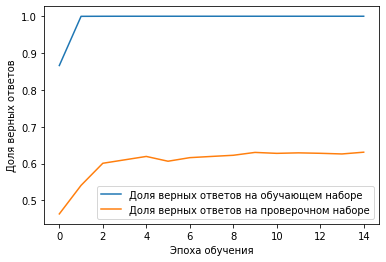

In [ ]:
dim = 256
model2, embed2 = createEmbeddingModel(dim=dim)
history = model2.fit(xTrain, yTrain, epochs=15, batch_size=64, verbose=1, validation_data=(xTest, yTest))
                     
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()                   
            

In [ ]:
zTrain2 = embed2.predict(ids)
zTrain2 = zTrain2.reshape(-1, dim)
zTrain2.shape

(50000, 256)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


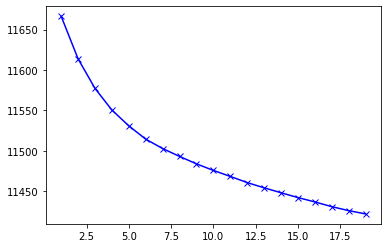

CPU times: user 24min 36s, sys: 5min 16s, total: 29min 52s
Wall time: 23min 34s


In [ ]:
%%time
n_clusters = 20               # Зададим количество кластеров
cost = []                     # Создаем пустой список
for i in range(1, n_clusters): # Пробегаем по списку от 1 до n_clusters
    kmean = KMeans(i)           # Создаем объект KMeans с i-классами
    kmean.fit(zTrain2)   # Проводим кластеризацию zTrain2
    cost.append(kmean.inertia_) # Добавляем в cost элемент kmean.inertia_
    print(i, end=' ')
print()

# Отобразим значения списка cost на графике
plt.plot([i for i in range(1, n_clusters)], cost, 'bx-')
plt.show()